# 0. Import libraries

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install geopy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_18456/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


In [4]:
poi_df = poi_df[['lat', 'lon']]

In [5]:
def get_n_poi(lat, lon, poi_df, radius=0.001):
    # radius = 0.03 -> 3km
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

In [6]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)

In [7]:
def lambda_ratio(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    if not math.isnan(n_room) and not math.isnan(n_bathroom):
        return n_room/max(1, n_bathroom) 
    else:
        return np.nan
    
def lambda_m2_per_bathrooms(x):
    n_room = x['n_rooms']
    n_bathroom = x['n_bathrooms']
    m2 = x['surface']
    if not math.isnan(n_bathroom) and not math.isnan(m2):
        return m2/max(1, n_room*3 + n_bathroom)
    else:
        return np.nan

In [8]:
train_df['ratio'] = train_df.apply(lambda x: lambda_ratio(x), axis=1)
train_df['m2_per_bathrooms'] = train_df.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)

In [9]:
# drop id
train_df.drop('id', axis=1, inplace=True)

In [10]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

In [11]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [12]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [13]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

In [14]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [15]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_train), columns=x_train.columns)
y_scaler = StandardScaler()
y_train = pd.DataFrame(y_scaler.fit_transform(y_train.values.reshape(-1, 1)), columns=['price'])

In [17]:
from sklearn.impute import KNNImputer
x_imputer = KNNImputer()
x_train = pd.DataFrame(x_imputer.fit_transform(x_train), columns=x_train.columns)

In [18]:
train_df = pd.concat([x_train, y_train], axis=1)

In [19]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)

In [20]:
train_df = train_df[filtered_entries].reset_index(drop=True)
new_shape = train_df.shape[0]

In [21]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 43904
percentage of rows removed: 5.199516324062878%


In [22]:
x_train = train_df.drop('price', axis=1)
y_train = train_df['price']

In [23]:
from sklearn.preprocessing import Normalizer
x_normalizer = Normalizer()
x_train = pd.DataFrame(x_normalizer.fit_transform(x_train), columns=x_train.columns)

In [24]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
sorted(rf.feature_importances_, reverse=True)

[0.4246426669903998,
 0.1520746366467346,
 0.056460919603971524,
 0.04833572837079249,
 0.032800447795732636,
 0.031102320097599046,
 0.028579350210934655,
 0.027106223088009865,
 0.024480531117578058,
 0.022516621117218878,
 0.022211762253986342,
 0.02206137904791015,
 0.021448594191410587,
 0.021296058824032977,
 0.019886479525757096,
 0.01665260080918474,
 0.01484715126346236,
 0.013496529045284216]

<BarContainer object of 18 artists>

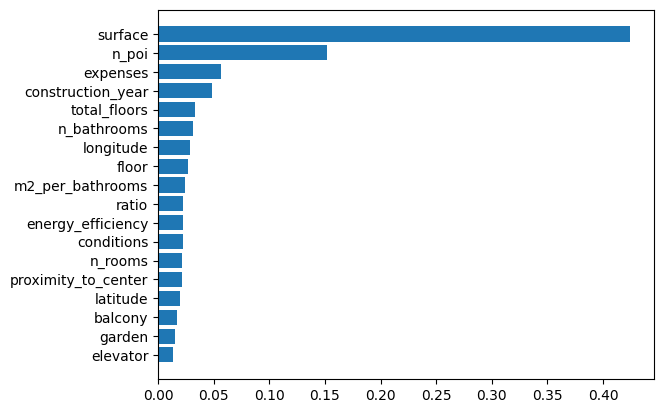

In [25]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor(),
    'SVR': SVR()
}

In [27]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x_train, y_train)

model: LinearRegression
model: RandomForestRegressor
model: GradientBoostingRegressor
model: KNeighborsRegressor
model: DecisionTreeRegressor
model: MLPRegressor
model: SVR


In [28]:
from sklearn.model_selection import cross_val_score
def evaluate_model(model, x, y, y_scaler, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, x, y, cv=5, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}'.format(scores.mean()))
    print('std: {}'.format(scores.std()))
    # plot scatter plot of y_pred vs y_true
    y_pred = y_scaler.inverse_transform(model.predict(x).reshape(-1, 1))
    y = y_scaler.inverse_transform(y.values.reshape(-1, 1))
    plt.scatter(y, y_pred)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.title('{}'.format(model))
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()
    plt.close()
    return scores

In [29]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0} for model_name in models.keys()}

model: LinearRegression
scores: [-0.09855831 -0.07601424 -0.08464961 -0.08932543 -0.0830045 ]
mean: -0.08631041979431008
std: 0.007467260436884328


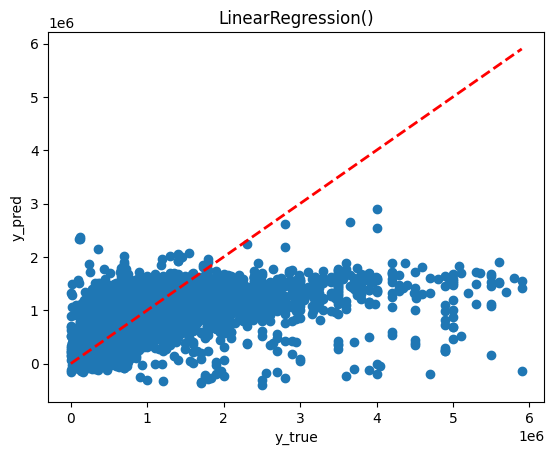

model: RandomForestRegressor
scores: [-0.06628034 -0.04533984 -0.05660199 -0.05697031 -0.05214355]
mean: -0.055467206114100644
std: 0.006842237358223509


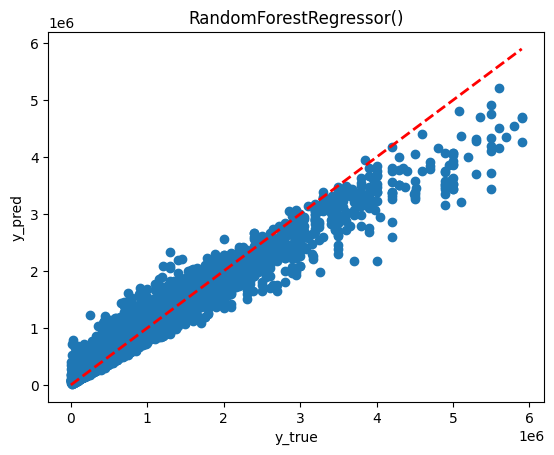

model: GradientBoostingRegressor
scores: [-0.07107719 -0.05088574 -0.06249201 -0.06438008 -0.05651834]
mean: -0.06107067101200999
std: 0.006892884379603958


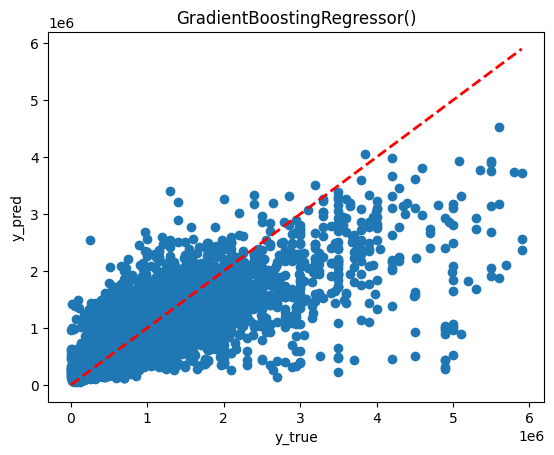

model: KNeighborsRegressor
scores: [-0.08191035 -0.06265444 -0.06825953 -0.07545405 -0.06463797]
mean: -0.07058326816030387
std: 0.007150383259751926


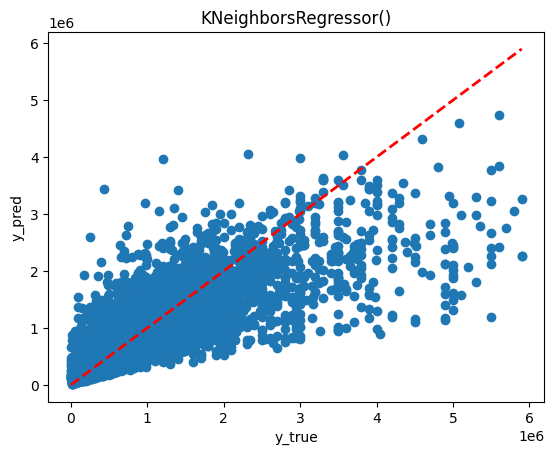

model: DecisionTreeRegressor
scores: [-0.13762826 -0.09230447 -0.11435135 -0.13315259 -0.11145979]
mean: -0.11777929346794354
std: 0.01631547348543332


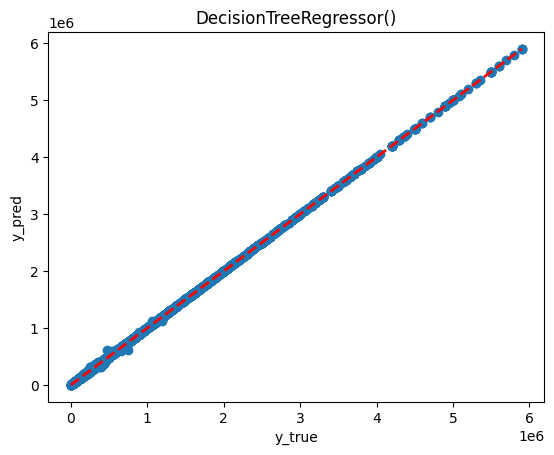

model: MLPRegressor
scores: [-0.07056087 -0.04901408 -0.06069546 -0.06372556 -0.05595459]
mean: -0.05999011135606843
std: 0.007251906503874142


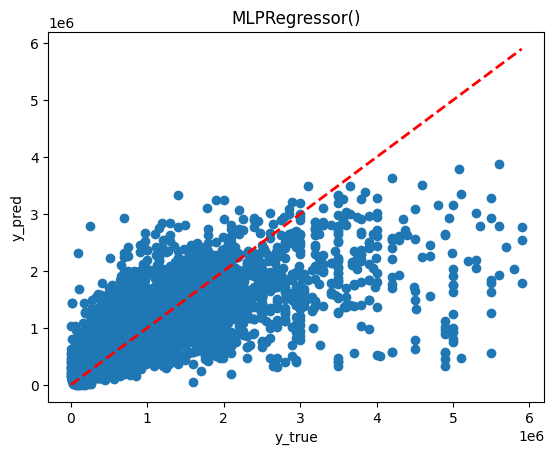

model: SVR
scores: [-0.07131119 -0.05023837 -0.06063401 -0.06520783 -0.05515536]
mean: -0.06050935419140534
std: 0.007388222764832727


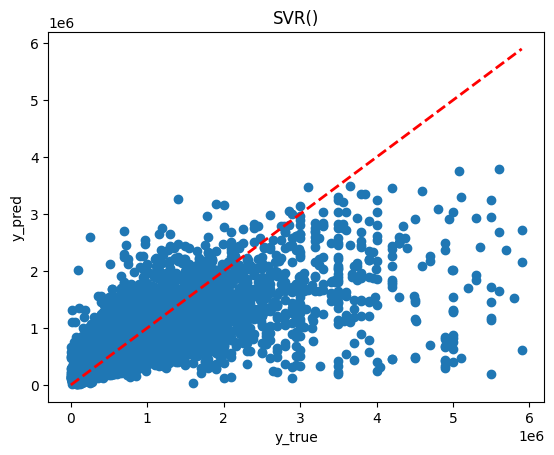

In [30]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    MSE_scores = evaluate_model(model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [31]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

,model,MSE_mean,MSE_std
0,RandomForestRegressor,0.055467,0.006842
1,MLPRegressor,0.059990,0.007252
2,SVR,0.060509,0.007388
3,GradientBoostingRegressor,0.061071,0.006893
4,KNeighborsRegressor,0.070583,0.007150
5,LinearRegression,0.086310,0.007467
6,DecisionTreeRegressor,0.117779,0.016315


In [35]:
def x_test_preprocessing(x_test, map_conditions, x_scaler, x_imputer, x_normalizer):
    x_test['n_poi'] = x_test.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    x_test['ratio'] = x_test.apply(lambda x: lambda_ratio(x), axis=1)
    x_test['m2_per_bathrooms'] = x_test.apply(lambda x: lambda_m2_per_bathrooms(x), axis=1)
    x_test['garden'] = x_test['garden'].fillna(False)
    x_test['balcony'] = x_test['balcony'].fillna(False)
    x_test['garden'] = x_test['garden'].apply(lambda x: 1 if x == True else 0)
    x_test['balcony'] = x_test['balcony'].apply(lambda x: 1 if x == True else 0)
    x_test['conditions'] = x_test['conditions'].apply(lambda x: map_conditions[x])
    x_test['conditions'] = x_test['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_imputer.transform(x_test), columns=x_test.columns)
    x_test = pd.DataFrame(x_normalizer.transform(x_test), columns=x_test.columns)
    return x_test

In [38]:
test_id = test_df['id']
x_test = test_df.drop('id', axis=1)
x_test = x_test_preprocessing(x_test, map_conditions, x_scaler, x_imputer, x_normalizer)

In [40]:
def submission(model, filename, y_scaler):
    y_pred = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
    y_pred = pd.DataFrame(y_pred, columns=['price'])
    submission_df = pd.concat([test_id, y_pred], axis=1)
    submission_df.to_csv(filename, index=False)
    return

In [42]:
for model_name, model in models.items():
    submission(model, 'submission/{}.csv'.format(model_name), y_scaler)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [43]:
# tuning random forest regressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  37.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  37.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  37.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  38.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  39.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  39.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  40.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_est

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=600; total time= 2.5min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=600; total time= 2.5min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=600; total time= 2.5min
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=400; total time= 1.7min
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=400; total time= 1.7min
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=400; total time= 1.7min
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=400; total time= 1.7min
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=400; total time= 1.7min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=200; total time=  37.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, n_estimators=600; total time= 2.4min
[CV] END bootstrap=Fal

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 600}

scores: [-0.06494641 -0.04402777 -0.05374639 -0.05462314 -0.04991911]
mean: -0.05345256389959653
std: 0.006853861202567752


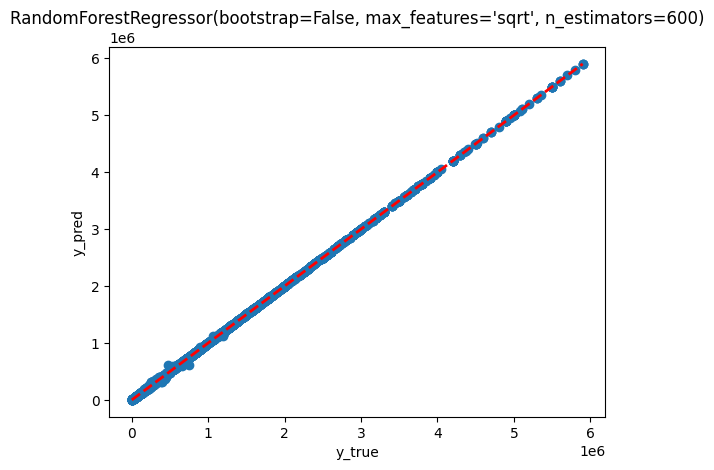

MSE: 0.053 (0.007 std)


In [44]:
tuned_model = RandomForestRegressor(**grid_search.best_params_)
tuned_model.fit(x_train, y_train)
MSE_score = evaluate_model(tuned_model, x_train, y_train, y_scaler, scoring='neg_mean_squared_error')
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

In [45]:
submission(tuned_model, 'submission/tuned_model.csv', y_scaler)